Metodo:

    ResNet-FC-1000: Ridimensiona l'immagine a 224x224; collega un "hook" all'output del livello "fc" dell'architettura pre-addestrata ResNet per ottenere un tensore di dimensione 1000.  

    ** Spiegare il metodo nel dettaglio **

Import

In [17]:
# Librerie principali
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import seaborn as sns
from PIL import Image
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler, normalize
from collections import defaultdict, Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Setup

In [22]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()


#funzione di creazione dei file
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "resnetfc_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "resnetfc_part2.npz")


# Task 1-2

Implementa un programma che estrae e memorizza i descrittori di feature per tutte le immagini nel set di dati

In [23]:
def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Estrae le feature del layer fully connected (fc) di ResNet50 da un'immagine.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[ERRORE] Immagine non valida {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    fc_output = []

    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    if fc_output:
        return fc_output[0].squeeze(0).cpu().numpy()
    else:
        print(f"[ERRORE] Nessun output FC per {image_path}")
        return None

Elaborazione Batch e Salvataggio Feature in .npz

In [24]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_fc_features_from_image(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

# Task 3

 Implementa un programma che, dato il nome di un file immagine e un valore "k", restituisce e visualizza le k immagini più simili in base a ciascun modello visivo - selezionerai l'appropriata misura di distanza/similarità per ciascun modello di feature.  Per ogni corrispondenza, elenca anche il corrispondente punteggio di distanza/similarità. 

  *Retrieval: Immagini più Simili (distanza coseno)*
 

In [25]:
def find_k_similar_cosine(img_path, k):
    """
    Trova le k immagini più simili rispetto a una query, usando la distanza coseno.
    """
    query_feature = extract_fc_features_from_image(img_path, model, preprocess, device)
    if query_feature is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = cosine_distances(feat_matrix_part1, query_feature).flatten()

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

Memorizzazione 

In [26]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnetfc_part1")
process_and_save_features("Part2", subfolders, "resnetfc_part2")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnetfc_part1
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnetfc_part2
[FINE] Totale immagini processate: 3006



Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg
1. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.0000
2. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0604
3. brain_glioma_0633.jpg | Classe: brain_glioma | Distanza: 0.0684
4. brain_glioma_0312.jpg | Classe: brain_glioma | Distanza: 0.0717
5. brain_glioma_0437.jpg | Classe: brain_glioma | Distanza: 0.0719


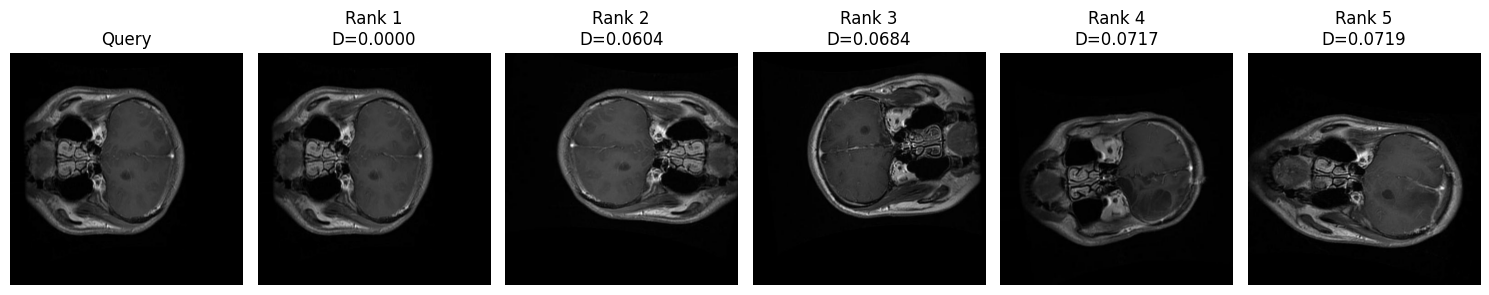

In [27]:

# Test su immagine di query
query_img = "Part1/brain_glioma/brain_glioma_0017.jpg"
find_k_similar_cosine(query_img, k=5)

# Task 4:

 Implementa un programma che, dati (a) un file immagine di query della parte 2, (b) uno spazio di feature selezionato dall'utente e (c) un numero intero positivo k (k<=2), identifica ed elenca le k etichette di corrispondenza più probabili, insieme ai loro punteggi, nello spazio di feature selezionato.    

In [28]:
def task4_predict_labels_resnetfc(query_img_path, k, extractor_fn, features, labels, metric="euclidean"):
    """
    Predict top-k labels for query image using ResNet FC features.
    extractor_fn: funzione che prende image_path e restituisce feature numpy array
    features: matrice numpy (N, d)
    labels: array di stringhe (N,)
    metric: "euclidean" o "cosine"
    """
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")

    def compute_metric(query_feat, target_feats, metric):
        query_feat = query_feat.reshape(1, -1)
        if metric == "euclidean":
            # distanza euclidea tra query_feat e tutti target_feats
            return np.linalg.norm(target_feats - query_feat, axis=1)
        elif metric == "cosine":
            # similarità coseno tra query_feat e tutti target_feats
            # sim = (A·B) / (|A||B|), distanza = 1 - sim
            dot_prod = np.dot(target_feats, query_feat.T).flatten()
            norm_feats = np.linalg.norm(target_feats, axis=1)
            norm_query = np.linalg.norm(query_feat)
            cosine_sim = dot_prod / (norm_feats * norm_query + 1e-10)
            cosine_dist = 1 - cosine_sim  # distanza coseno
            return cosine_dist
        else:
            raise ValueError("Metric must be 'euclidean' or 'cosine'")

    def predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        scores = []
        for label in unique_labels:
            class_feats = features[labels == label]
            dists = compute_metric(query_feat, class_feats, metric)
            scores.append(dists.mean())
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:  # cosine distanza: più piccola è meglio
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

    def predict_top_k_labels_prototype(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        prototypes = []
        for label in unique_labels:
            class_feats = features[labels == label]
            prototypes.append(class_feats.mean(axis=0))
        prototypes = np.vstack(prototypes)
        scores = compute_metric(query_feat, prototypes, metric)
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

    predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric)
    predict_top_k_labels_prototype(query_img_path, k, features, labels, metric)


Test

In [29]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="euclidean"
)

task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="cosine"
)



======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: euclidean]
Classe: brain_tumor | Score medio: 41.4859
Classe: brain_menin | Score medio: 44.3253

[STRATEGIA: prototipo di classe - metrica: euclidean]
Classe: brain_menin | Score: 28.2170
Classe: brain_tumor | Score: 28.2899

======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: cosine]
Classe: brain_tumor | Score medio: 0.1648
Classe: brain_menin | Score medio: 0.2079

[STRATEGIA: prototipo di classe - metrica: cosine]
Classe: brain_tumor | Score: 0.0877
Classe: brain_menin | Score: 0.0958


# Task 5

Implementa un programma che (a) dato uno dei modelli di feature, (b) un valore k specificato dall'utente, (c) una delle tre tecniche di riduzione della dimensionalità (SVD, LDA, k-means) scelte dall'utente, riporta le prime k semantiche latenti estratte nello spazio di feature selezionato.    

-Memorizza le semantiche latenti in un file di output adeguatamente nominato.    

-Elenca le coppie imageID-peso, ordinate in ordine decrescente di pesi.    


In [30]:
def task5_latent_semantics_resnetfc(feature_model_path, technique, k):
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa
            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


def plot_latent_space_2d(X_transformed, labels, technique, k):
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [ ]:
Test

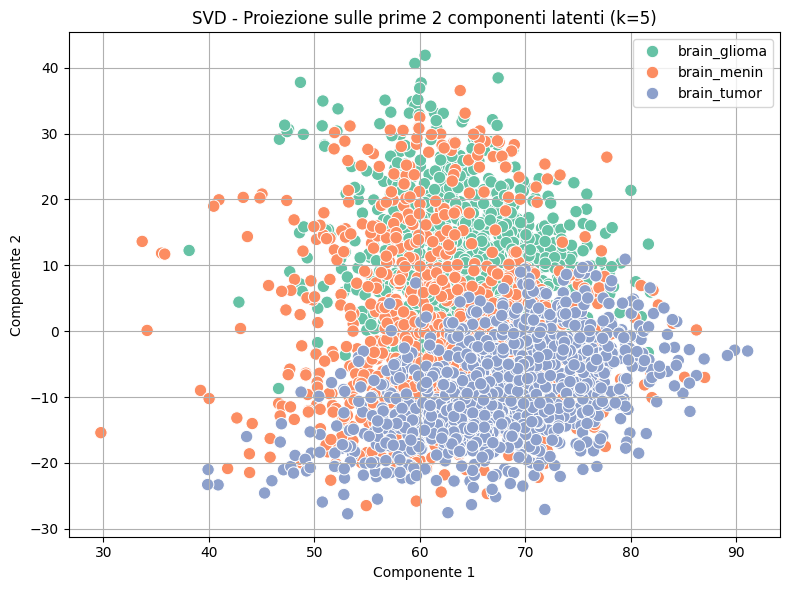

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnetfc_part1_k5.txt


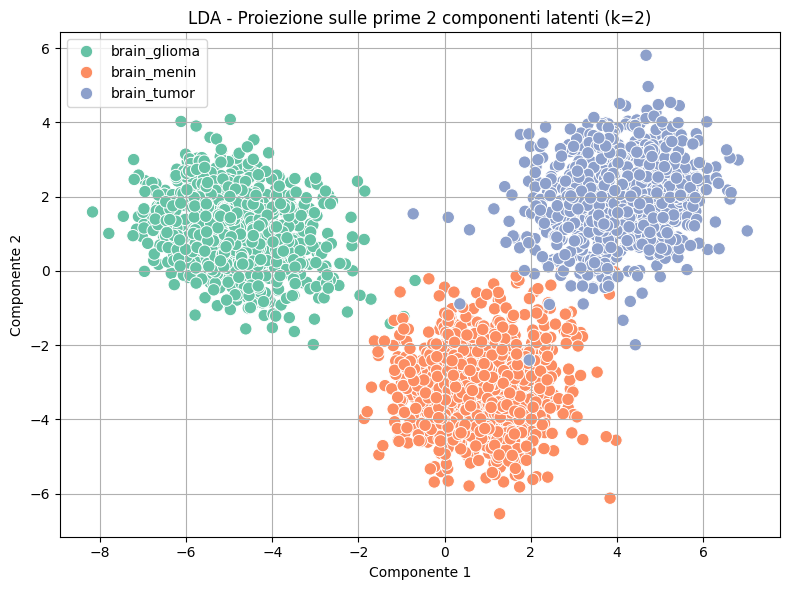

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnetfc_part1_k2.txt


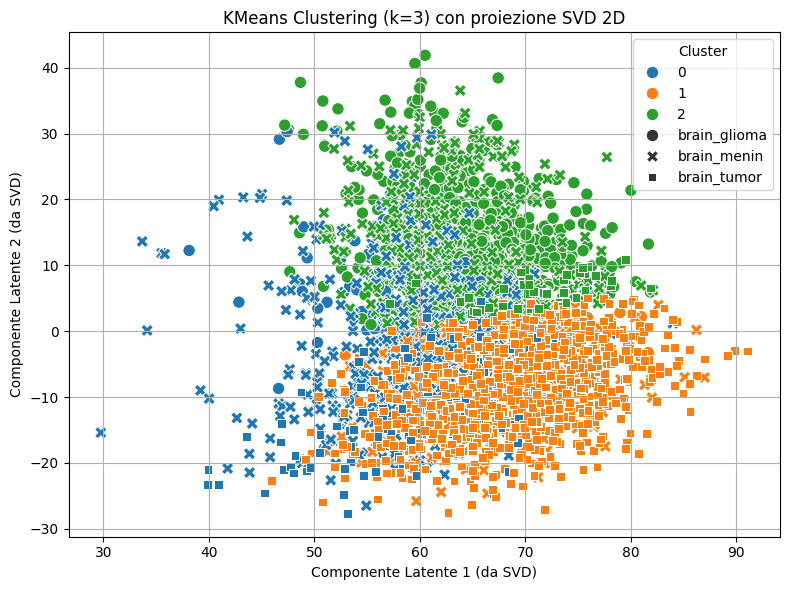

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnetfc_part1_k3.txt


In [31]:
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="svd", k=5)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="lda", k=2)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="kmeans", k=3)

# Task 6


>Task 6a:

 Implementa un programma che calcola e stampa la "inherent dimensionality" associata alle immagini della parte 1.    


In [43]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values



> Task 6b: 

Implementa un programma che calcola e stampa la "dimensionalità intrinseca" (numero di dim indipendenti minime necassari per rappresentare set) associata a ciascuna etichetta univoca delle immagini della parte 1.  

In [44]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


Test

In [ ]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

# Task 7

Implementa un programma che,per ciascuna etichetta univoca l, calcola le corrispondenti k semantiche latenti (a tua scelta) associate alle immagini della parte 1, e
per le immagini della parte 2, prevede le etichette più probabili utilizzando distanze/similarità calcolate sotto le semantiche latenti specifiche dell'etichetta.    
Il sistema dovrebbe anche fornire valori di precision, recall, and F1-score per etichetta, nonché un valore di accuratezza complessiva.   

In [54]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

Test

In [ ]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

# Task 8

Implementa un programma che, per ciascuna etichetta univoca l, calcola i corrispondenti c cluster più significativi associati alle immagini della parte 1 (utilizzando l'algoritmo DBScan);
i cluster risultanti devono essere visualizzati sia
come nuvole di punti colorate in modo diverso in uno spazio MDS a 2 dimensioni, sia
come gruppi di miniature di immagini.

In [ ]:
def load_features(npz_path):
    """
    Carica features, labels e filenames da un file .npz.
    Ritorna:
      - features: array NumPy di shape (N, D)
      - labels:   array di shape (N,)
      - filenames: array di shape (N,)
    """
    data = np.load(npz_path, allow_pickle=True)
    features = data['features']
    labels = data['labels']
    filenames = data.get('filenames', np.array([f"img_{i}" for i in range(len(features))]))
    return features, labels, filenames


def extract_color_moments(img_path):
    """
    Estrae i Color Moments su griglia 10×10 (900‐dim) da un'immagine.
    Restituisce una lista di 900 float, oppure None se l'immagine non viene letta.
    """
    from scipy.stats import skew

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        return None
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (300, 100))

    h_cell = 100 // 10  # 10
    w_cell = 300 // 10  # 30
    feature = []
    for i in range(10):
        for j in range(10):
            cell = img_resized[i*h_cell:(i+1)*h_cell, j*w_cell:(j+1)*w_cell, :]
            for c in range(3):
                canal = cell[:, :, c].flatten().astype(np.float64)
                m = float(np.mean(canal))
                s = float(np.std(canal))
                sk = float(skew(canal))
                feature.extend([m, s, sk])
    return feature  # lunghezza = 10×10×3×3 = 900


def lista_percorso_immagini(cartella_root):
    """
    Ritorna la lista di tutti i percorsi di file immagine (.jpg, .jpeg, .png)
    presenti ricorsivamente sotto cartella_root.
    """
    img_paths = []
    for root, dirs, files in os.walk(cartella_root):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_paths.append(os.path.join(root, f))
    return img_paths


# -----------------------------------------------
# 2) Funzione per PCA + DBSCAN
# -----------------------------------------------

def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni via PCA, poi applica DBSCAN.
    Restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA → riduco da {features.shape[1]} a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


# -----------------------------------------------
# 3) Funzione per selezionare i c cluster più popolosi
# -----------------------------------------------

def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più voluminosi" da restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1), 
    ordinati per frequenza decrescente. Se ci sono meno di c cluster, restituisce tutti.
    """
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None)  # rimuovo il rumore (-1), se presente

    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []

    most_common = label_counts.most_common(c)  # e.g. [(lbl1, cnt1), (lbl2, cnt2), ...]
    top = [int(lbl) for lbl, _ in most_common]

    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster validi (meno di {c}).")
    return top


# -----------------------------------------------
# 4) Funzione per disegnare i cluster in 2D con MDS
# -----------------------------------------------

def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle feature originali (non PCA), normalizzazione interna.
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi corrispondenti ai cluster "significativi".
    metric: tipo di distanza per l’MDS (default 'euclidean').
    Plotta un scatter 2D dove i punti di top_clusters hanno colori diversi,
    tutti gli altri (rumore o cluster secondari) appaiono in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le feature originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Applico MDS (2D) su features_scaled
    mds = MDS(n_components=2, random_state=42, dissimilarity=metric)
    Y = mds.fit_transform(features_scaled)

    # 3) Scatterno i punti
    import matplotlib
    cmap = matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i, 0], Y[i, 1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # rumore (-1) o cluster non top
            plt.scatter(Y[i, 0], Y[i, 1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS dimension 1")
    plt.ylabel("MDS dimension 2")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------
# 5) Funzione per visualizzare miniature per ciascun cluster
# -----------------------------------------------

def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia images[i] corrisponde a features[i].
    cluster_labels: array (N,) di interi per ogni immagine.
    top_clusters: lista di interi che vogliamo visualizzare.
    thumb_size: dimensione (w, h) di ogni miniatura.
    Per ciascun cluster in top_clusters stampa a video una griglia di miniature.
    """
    for cluster_id in top_clusters:
        # Indici delle immagini appartenenti a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        max_display = min(len(idxs), 16)
        if max_display == 0:
            continue

        n = int(np.ceil(np.sqrt(max_display)))  # dimensione griglia n×n
        plt.figure(figsize=(n * 1.5, n * 1.5))

        for j, i_img in enumerate(idxs[:max_display]):
            try:
                img = Image.open(images[i_img]).convert('RGB')
            except Exception as e:
                print(f"[WARN] Impossibile aprire {images[i_img]}: {e}")
                continue

            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            ax = plt.subplot(n, n, j + 1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()


# ================================
# 6) BLOCCHETTO PRINCIPALE PER TASK 8
# ================================

# 6.1) Parametri DBSCAN + PCA + numero di cluster da visualizzare
eps = 5.0            # DBSCAN eps (distanza massima per considerare punti vicini)
min_samples = 5      # DBSCAN min_samples (numero minimo di punti per formare un cluster)
n_components = 50    # quante componenti PCA mantenere prima di DBSCAN
c = 5                # quanti cluster più voluminosi voglio visualizzare per ciascuna label

# 6.2) Directory di output (facoltativa, per salvare figure o miniature)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 6.3) Carico features di Part1 e Part2
feat_matrix_part1, lbls_part1, flname_part1 = load_features("color_moments_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features("color_moments_part2.npz")

# 6.4) Costruisco lista di tutti i percorsi completi delle immagini di Part1
base_folder = "Part1"  # modifica se il percorso è diverso (es. "/mnt/data/Part1")
images_full = [
    os.path.join(base_folder, lbl, fname)
    for fname, lbl in zip(flname_part1, lbls_part1)
]

# 6.5) Pre‐elaborazione delle feature di Part1: centering + L2 normalization
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)  # (N1, D)

# 6.6) Prendo tutte le label uniche di Part1 (es. ["brain_glioma", "brain_menin", ...])
unique_labels = np.unique(lbls_part1)

# 6.7) Per ciascuna label, filtro le righe corrispondenti e applico PCA+DBSCAN
for lbl in unique_labels:
    print("\n" + "="*40)
    print(f"[INFO] Elaboro label: {lbl}")
    print("="*40)

    # 6.7.1) Indici di Part1 corrispondenti a questa label
    mask_lbl = (lbls_part1 == lbl)
    features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, D)
    images_label   = np.array(images_full)[mask_lbl]  # tutti i percorsi di file per questa label

    # 6.7.2) Se non ci sono abbastanza immagini, salto
    if features_label.shape[0] < min_samples:
        print(f"[WARN] Solo {features_label.shape[0]} immagini per label '{lbl}' < min_samples; salto.")
        continue

    # 6.7.3) Applico PCA + DBSCAN sui vettori originali (senza normalizzazione)
    # Nota: qui uso direttamente features_label (900‐dim Raw). Se vuoi usare feat_normed,
    # devi indicizzare nello stesso ordine; in ogni caso per DBSCAN va bene anche raw + scaling interno.
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    unique_clusters = np.unique(cluster_labels)
    print(f"[INFO] Cluster-labels trovati: {unique_clusters}")

    # 6.7.4) Individuo i c cluster più voluminosi (escludendo -1)
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 6.7.5) MDS 2D dei punti di questa label con i cluster evidenziati
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se vuoi salvare il grafico anziché visualizzarlo, sostituisci plt.show() con:
    # plt.savefig(os.path.join(output_base, f"{lbl}_MDS_clusters.png"))
    # plt.close()

    # 6.7.6) Mostro le miniature dei top_clusters
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,            # lista di percorsi
        cluster_labels,          # array di lunghezza n_i
        top_clusters,            # i cluster “significativi” selezionati
        thumb_size=(64, 64)
    )
    # Se vuoi salvare le miniature anziché mostrare con plt.show(), puoi modificare
    # show_cluster_thumbnails per usare plt.savefig() in un path dedicato.

print("\n[FINITO] Task 8 completato per tutte le label di Part1.")

# Task 9

Implementa un programma che, dati le immagini della parte 1:

*crea un classificatore m-NN (per una m specificata dall'utente),

*crea un classificatore ad albero decisionale,
Per questo task, puoi utilizzare lo spazio delle feature di tua scelta.    

Per le immagini della parte 2, prevede le etichette più probabili utilizzando il classificatore selezionato dall'utente.
Il sistema dovrebbe anche fornire valori di precisione, richiamo e punteggio F1 per etichetta, nonché un valore di accuratezza complessiva.    


In [36]:


# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.94      0.96      0.95      1002
 brain_menin       0.93      0.87      0.90      1002
 brain_tumor       0.91      0.95      0.93      1002

    accuracy                           0.93      3006
   macro avg       0.93      0.93      0.93      3006
weighted avg       0.93      0.93      0.93      3006

Accuratezza complessiva m-NN: 0.926480372588157
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.81      0.81      0.81      1002
 brain_menin       0.69      0.69      0.69      1002
 brain_tumor       0.75      0.75      0.75      1002

    accuracy                           0.75      3006
   macro avg       0.75      0.75      0.75      3006
weighted avg       0.75      0.75      0.75      3006

Accuratezza complessiva Decision Tree: 0.7488356620093147


# Task 10

> 10a:

 Implementa uno strumento di Locality Sensitive Hashing (LSH) (per la distanza euclidea) che prende come input (a) il numero di livelli, L, (b) il numero di hash per livello, h, e (c) un insieme di vettori come input e crea una struttura di indice in memoria contenente l'insieme di vettori dato. 

Vedi:
"Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions" (di Alexandr Andoni e Piotr Indyk). Communications of the ACM, vol. 51, no. 1, 2008, pp. 117-122.    



In [32]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [33]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
print("mean_vec.shape =", mean_vec.shape)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 12                        # numero di funzioni concatenati in ciascuna tavola
r = 0.2                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


mean_vec.shape = (1000,)
[INFO] LSH quantizzato costruito: D=1000, L=10, h=12, r=0.2


> 10b:

 Implementa un algoritmo di ricerca di immagini simili utilizzando questa struttura di indice che memorizza le immagini della parte 1 e un modello visivo di tua scelta (il modello visivo combinato deve avere almeno 256 dimensioni): per una data immagine di query e un numero intero t, 
 
*visualizza le t immagini più simili,
*fornisce il numero di immagini univoche e il numero complessivo di immagini considerate durante il processo.    

In [34]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    raw_q = np.array(extract_fc_features_from_image(img_path, model, preprocess, device), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    print("raw_q.shape =", raw_q.shape)        # ad esempio (1024,)
    print("mean_vec.shape =", mean_vec.shape)  # ad esempio (900,) o (2048,) o altro
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


Test

raw_q.shape = (1000,)
mean_vec.shape = (1000,)

[LSH-Quant] Top 3 simili a: Part2/brain_glioma/brain_glioma_1409.jpg
[LSH-Quant] Immagini uniche considerate: 0
[LSH-Quant] Immagini totali controllate: 0


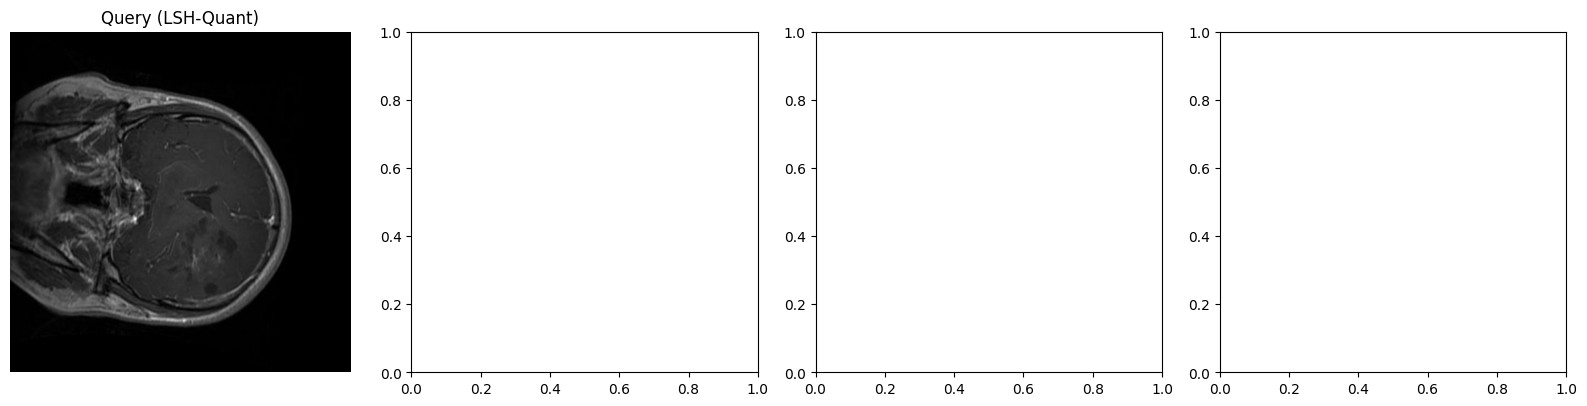

In [35]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 3                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)


Index LSH costruito: 5 tabelle, 1 hash per tabella.

----- Risultati LSH (Task 10) -----
Query: brain_glioma_1409.jpg
Num. candidati totali considerati (con duplicati): 784
Num. candidati unici considerati: 703
Indici dei top 5 vicini trovati: [355, 461, 958, 56, 920]

